# Glassdoor Review - NLP

Natural Language Processing - Group Assignment

Team B - **Timo Bachmann, William Kingwill, Qing Loh, Francisco Mansilla, Alberto de Roni, Julius von Selchow, Umut Varol**


**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## Agenda

**I. Python environment setup**

**II. Data source set-up**
  
**III. EDA/Pre-Processing**
  
**IV. Classification**
  
**V. Sentiment Polarity and Subjectivity**
  1. Title
  2. Pro comments
  3. Con comments
  
**VI. Overall Review Sentiment Calculation**

**VII. Sentiment Evaluation**

**VIII. Export Final Output**

**IX. Information Retrieval**

# I. Setup Environment

In [198]:
import pandas as pd
import numpy as np

import os
import json
import glob
import matplotlib.pyplot as plt
import spacy
import string
from multiprocessing import Pool, cpu_count
from string import punctuation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import nltk

from collections import defaultdict
from pathlib import Path

#from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# # styling
# #from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
# display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size
# plt.style.use("fivethirtyeight")
# sns.set_style('whitegrid')
# sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

# II. Data source setup

In [199]:
#path = r'/Users/jvs22/Desktop/IE Courses/Term 3/NLP/Group Project/Glassdoor/ALL_JSON_OUTPUTS' 
path = r'C:\Users\34603\IE Students\Las Bombas - Documents\NLP\ALL_JSON_OUTPUTS'    
all_files = glob.glob(os.path.join(path, "*.txt")) 

data = pd.DataFrame()
for file_ in all_files:
    file_df = pd.read_csv(file_)
    file_df['file_name'] = file_
    data = data.append(file_df)
    
data.head(3)

,date,employee_title,location,employee_status,review_title,years_at_company,helpful,pros,cons,advice_to_mgmt,rating_overall,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,recommends,positive_outlook,approves_of_CEO,file_name
0,Fri Dec 04 2020 10:16:51 GMT+0100 (hora estánd...,NaN,"San Jose, CA",Former Employee,Good Company,I worked at Adobe full-time for more than 10 y...,0,- Great Benefits - Great Comp - Very good culture,- Sometime too consensus driven,NaN,NaN,4.0,4.0,4.0,3.0,5.0,Recommends,Positive Outlook,Approves of CEO,C:\Users\34603\IE Students\Las Bombas - Docume...
1,Thu Nov 19 2020 04:31:24 GMT+0100 (hora estánd...,Project Manager,"New York, NY",Former Employee,adobe review,I worked at Adobe full-time,0,good people good environment good things,"nothing bad, good things everything",NaN,NaN,5.0,5.0,5.0,5.0,5.0,Recommends,Neutral Outlook,NaN,C:\Users\34603\IE Students\Las Bombas - Docume...
2,Thu Nov 19 2020 19:18:17 GMT+0100 (hora estánd...,Business Development Representative,"Lehi, UT",Current Employee,Phenomenal company that puts its employees exp...,I have been working at Adobe full-time for mor...,0,-Paid Holidays -Shutdown bi-annually -Maternit...,Aetna insurance has separate deductibles for m...,NaN,NaN,4.0,4.0,4.0,5.0,3.0,Recommends,Positive Outlook,Approves of CEO,C:\Users\34603\IE Students\Las Bombas - Docume...


In [200]:
#Calculate "rating_overall" column using the average of the other 5 rating columns
data['rating_overall'] = data.iloc[:,11:16].mean(axis=1)
data['rating_overall'] = round(data['rating_overall'])

#data.head(3)

In [201]:
#Extract Company name
data['Company'] = data.file_name.str.rsplit('\\',1,expand=True).iloc[:,1].str.rsplit('.',1,expand=True).iloc[:,0]
data['Company'] = data['Company'].str.upper()
data.head(3)

,date,employee_title,location,employee_status,review_title,years_at_company,helpful,pros,cons,advice_to_mgmt,...,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,recommends,positive_outlook,approves_of_CEO,file_name,Company
0,Fri Dec 04 2020 10:16:51 GMT+0100 (hora estánd...,NaN,"San Jose, CA",Former Employee,Good Company,I worked at Adobe full-time for more than 10 y...,0,- Great Benefits - Great Comp - Very good culture,- Sometime too consensus driven,NaN,...,4.0,4.0,4.0,3.0,5.0,Recommends,Positive Outlook,Approves of CEO,C:\Users\34603\IE Students\Las Bombas - Docume...,ADOBE
1,Thu Nov 19 2020 04:31:24 GMT+0100 (hora estánd...,Project Manager,"New York, NY",Former Employee,adobe review,I worked at Adobe full-time,0,good people good environment good things,"nothing bad, good things everything",NaN,...,5.0,5.0,5.0,5.0,5.0,Recommends,Neutral Outlook,NaN,C:\Users\34603\IE Students\Las Bombas - Docume...,ADOBE
2,Thu Nov 19 2020 19:18:17 GMT+0100 (hora estánd...,Business Development Representative,"Lehi, UT",Current Employee,Phenomenal company that puts its employees exp...,I have been working at Adobe full-time for mor...,0,-Paid Holidays -Shutdown bi-annually -Maternit...,Aetna insurance has separate deductibles for m...,NaN,...,4.0,4.0,4.0,5.0,3.0,Recommends,Positive Outlook,Approves of CEO,C:\Users\34603\IE Students\Las Bombas - Docume...,ADOBE


# III. EDA/Pre-Processing

*** 
1. Stop Words - common words that help to create sentence structure, but do not add any meaning to the idea that a sentence is trying to convey.


2. Part of Speech tagging - allows for the inclusion or exclusion of certain parts of speech (e.g. articles, conjunctions) if they are not excluded in the removal of stop words. Part of speech tagging also helps in lemmatizing the corpus. Many words can be more than one part of speech.


3. Lemmatization - Stemming involves removing endings from words to reduce each word to its stem (i.e. "working" is reduced to "work"). Lemmatization goes a step further, and reduces each word to its morphological root, or lemma, taking tense and other linguistic nuance into account (i.e. "is", "am", "are" become "be"). 


4. N-grams - essentially sequential groups of words that communicate a different idea together than they do apart.
***

## 3.1. EDA

### Analysing Rating Star Columns

#### How does the length of reviews relate to their star ratings?

In [202]:
# How is the length of review related to Star Rating?
data['review_length'] = (data['pros'].str.len() + data['cons'].str.len())/100

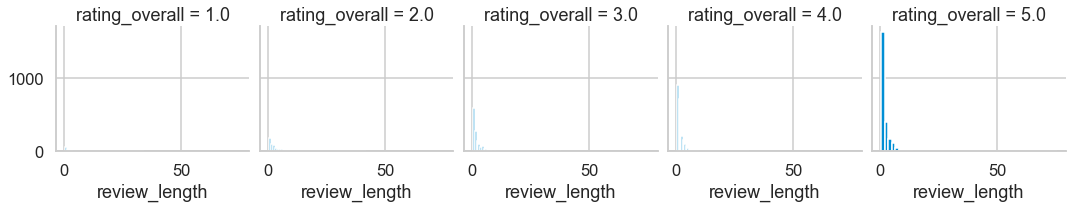

In [203]:
g = sns.FacetGrid(data=data, col='rating_overall')
g.map(plt.hist, 'review_length', bins=50)

Text(0.5, 1.0, 'Token Length vs Number of Reviews')

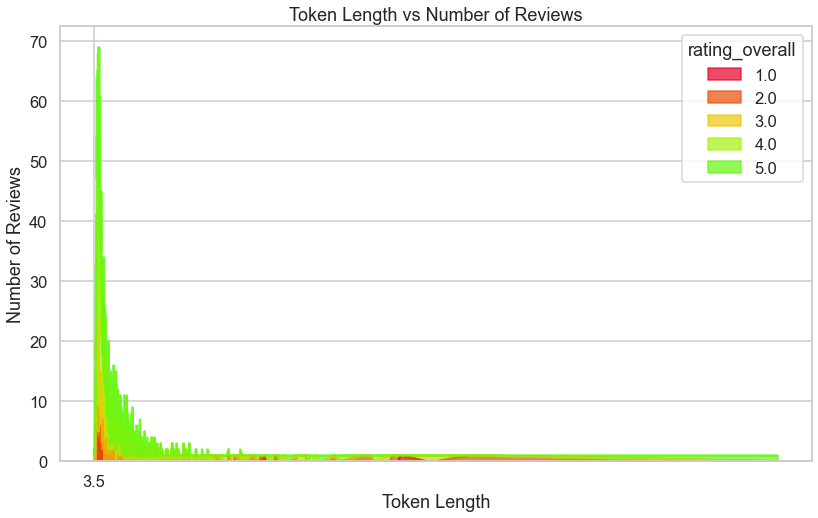

In [204]:
#set styling
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) # 1, 2, 3, 4, and 5 stars respectively

#create new column with pros and cons
data['review_length'] = (data['pros'].str.len() + data['cons'].str.len())
#calculate lengths
data['review_length_category'] = data.review_length.apply(lambda rl : rl/100)
df_with_initial_features_by_length_category_and_stars = data.groupby(['review_length_category', 'rating_overall'])
star_count_by_review_length_and_category = df_with_initial_features_by_length_category_and_stars.size()
star_count_by_review_length_in_units_of_10 = star_count_by_review_length_and_category.unstack(level=1)
whereNaN = np.isnan(star_count_by_review_length_in_units_of_10)
star_count_by_review_length_in_units_of_10[whereNaN] = 0
star_count_by_review_length_in_units_of_10.plot(kind='area', figsize=(12,8), color=colors, alpha=0.7)

plt.xlabel('Token Length')
review_length_range = (min(data.review_length_category), max(data.review_length_category));
xtick_labels = 10*np.arange(review_length_range[0], review_length_range[1], 10);
x = np.arange(review_length_range[0], review_length_range[1], 100);
plt.xticks(x, xtick_labels);

plt.ylabel('Number of Reviews')
plt.title('Token Length vs Number of Reviews')

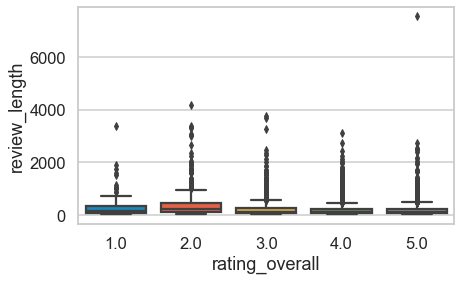

In [205]:
sns.boxplot(x='rating_overall', y='review_length', data=data)

***Looking at the plot above, there are some outliers, especially in the 5 star rating. Because of this, maybe text length won’t be such a useful feature to consider after all.***

#### How do the rating columns correlate with each other?

In [206]:
# trying to find correlations
stars = data.groupby('rating_overall').mean()
stars.corr()

,helpful,rating_balance,rating_culture,rating_career,rating_comp,rating_mgmt,review_length,review_length_category
helpful,1.000000,-0.879787,-0.923420,-0.907059,-0.855998,-0.898147,0.869770,0.869770
rating_balance,-0.879787,1.000000,0.993617,0.996881,0.968609,0.998095,-0.741098,-0.741098
rating_culture,-0.923420,0.993617,1.000000,0.995586,0.957609,0.997317,-0.792129,-0.792129
rating_career,-0.907059,0.996881,0.995586,1.000000,0.977529,0.995525,-0.746161,-0.746161
rating_comp,-0.855998,0.968609,0.957609,0.977529,1.000000,0.955990,-0.600868,-0.600868
rating_mgmt,-0.898147,0.998095,0.997317,0.995525,0.955990,1.000000,-0.780327,-0.780327
review_length,0.869770,-0.741098,-0.792129,-0.746161,-0.600868,-0.780327,1.000000,1.000000
review_length_category,0.869770,-0.741098,-0.792129,-0.746161,-0.600868,-0.780327,1.000000,1.000000


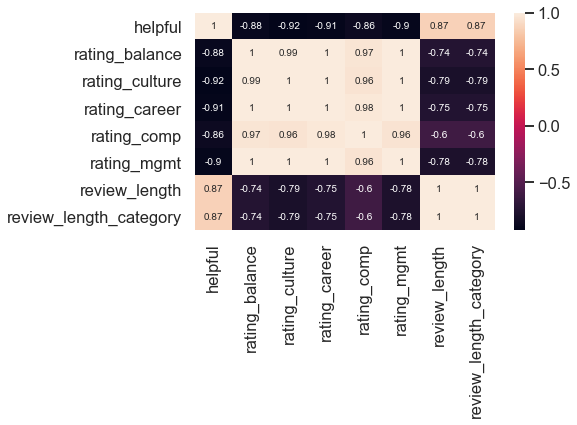

In [207]:
# visualising these correlations
sns.heatmap(data=stars.corr(), annot=True)

***As expected, all columns are highly correlated with each other meaning if one column is highly rated then chances are the other columns will most likely also be highly rated. As there are no significant findings, relationship between columns will also not be very useful to consider in our analysis.***

## 3.2. Pre-Processing

***Now it is time to preprocess the reviews because all these modifications will directly affect the classifier’s performance. As we are going to use words as features so we can use some text formatting techniques which will help us in feature extraction including removing punctuation marks/digits ,and also stop-words. In addition, the implementation of lemmatization words using NLTK can be workable to maximize the performance. Tokenization is the last step to break reviews up into words and other meaningful tokens.***

In [208]:
import re
nlp = spacy.load('en_core_web_sm')

In [209]:
s_stemmer = SnowballStemmer(language='english')

def processAll(text):
    
    text = [word for word in text.split()]
    #text = text.split()
    text = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in text]
    text = [words for words in text if words !='']
    text = [s_stemmer.stem(w) for w in text]
    #text = [words for words in text if words not in nlp.Defaults.stop_words]               
    
    return text

#### Feature Creation

In [210]:
# Wrapper function that encloses all the n-grams procedures

def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

In [211]:
negtn_regex = re.compile( r"""(?:
    ^(?:never|no|nothing|nowhere|noone|none|not|
        havent|hasnt|hadnt|cant|couldnt|shouldnt|
        wont|wouldnt|dont|doesnt|didnt|isnt|arent|aint
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [212]:
def get_pos_features(words):
    tags = {}
    tagged_words = [ 'has(%s)'% w+'_'+tag for w,tag in nltk.pos_tag(words)]
    
    for tw in tagged_words:
        tags[tw] = 1

    return tags

In [213]:
# Wrapper function for the extraction of features
def extract_features(text):
    features = {}
    
    words = processAll(text)

    word_features = get_word_features(words)
    features.update( word_features )

    negation_features = get_negation_features(words)
    features.update( negation_features )
    
#     pos_features = get_pos_features(words)
#     features.update( pos_features )

    return features

In [214]:
data['all_reviews'] = data['pros'] + " " + data['cons']

data['processed_features'] = data.all_reviews.apply(extract_features)

# IV. Classification

In [215]:
data_cleaned = data[data['rating_overall'].notnull()]

# Add sentiment label which will be used to train sentiment classifier
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1
# 1 is positive and 0 is not positive or negative

data_cleaned['Sentiment'] = data_cleaned['rating_overall'].map(getSentiment)
data_cleaned = data_cleaned[['all_reviews', 'processed_features', 'Sentiment']]

In [216]:
training_size = round(0.7*len(data_cleaned))
train_data = [(all_reviews, Sentiment) for all_reviews, Sentiment in data_cleaned[['all_reviews', 'Sentiment']].values[:training_size]]
validation_data  = [(all_reviews, Sentiment) for all_reviews, Sentiment in data_cleaned[['all_reviews', 'Sentiment']].values[training_size:]]

In [217]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,train_data)
v_validation = nltk.classify.apply_features(extract_features,validation_data)

In [218]:
max_ent_classifier = nltk.classify.MaxentClassifier
max_ent_class = max_ent_classifier.train(v_train, algorithm='GIS', max_iter=25)

print("Accuracy of the model = ", nltk.classify.accuracy(max_ent_class, v_validation))

  ==> Training (25 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.795
             2          -0.69292        0.797
             3          -0.69269        0.797
             4          -0.69246        0.797
             5          -0.69223        0.797
             6          -0.69200        0.797
             7          -0.69177        0.797
             8          -0.69155        0.797
             9          -0.69132        0.797
            10          -0.69109        0.797
            11          -0.69086        0.797
            12          -0.69064        0.797
            13          -0.69041        0.797
            14          -0.69018        0.797
            15          -0.68996        0.797
            16          -0.68973        0.797
            17          -0.68951        0.797
            18          -0.68928        0.797
            19          -0.68905        0.797
  

#### Insights

What do employees find most positive and most negative about their companies?
- Plot word frequency graph
- Plot wordcloud

In [219]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [220]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
#from stop_words import get_stop_words
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

STOPLIST = set(["n't", "'s", "'m", "ca", "'", "'re", "i've", 'poor', '-',
                'worst', 'place', 'make', 'thing', 'hour', 'low', 'high', 'bos',
                'good', 'great', 'awesome', 'excellent', 'job', 'best', 'lot',
                'wonderful', 'awful', 'work', 'amazing', 'suck', 'nice',
                'really', 'free', 'like', 'love', 'bad', 'terrible', 'care',
                'horrible', 'company', 'employee', 'staff', 'time', 'day',
                'week', 'month', 'year', 'need', 'better', 'just', 'decent'] +
               list(ENGLISH_STOP_WORDS))

top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

#a = data['lem_pros'].str.lower().str.cat(sep=' ')
a = data['pros'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

#### Frequency count of positive words

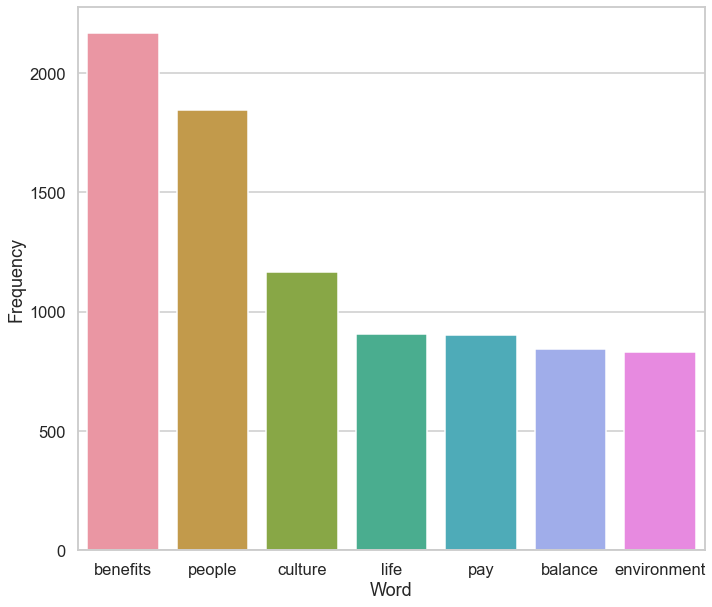

In [221]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

#### Wordcloud of positive words

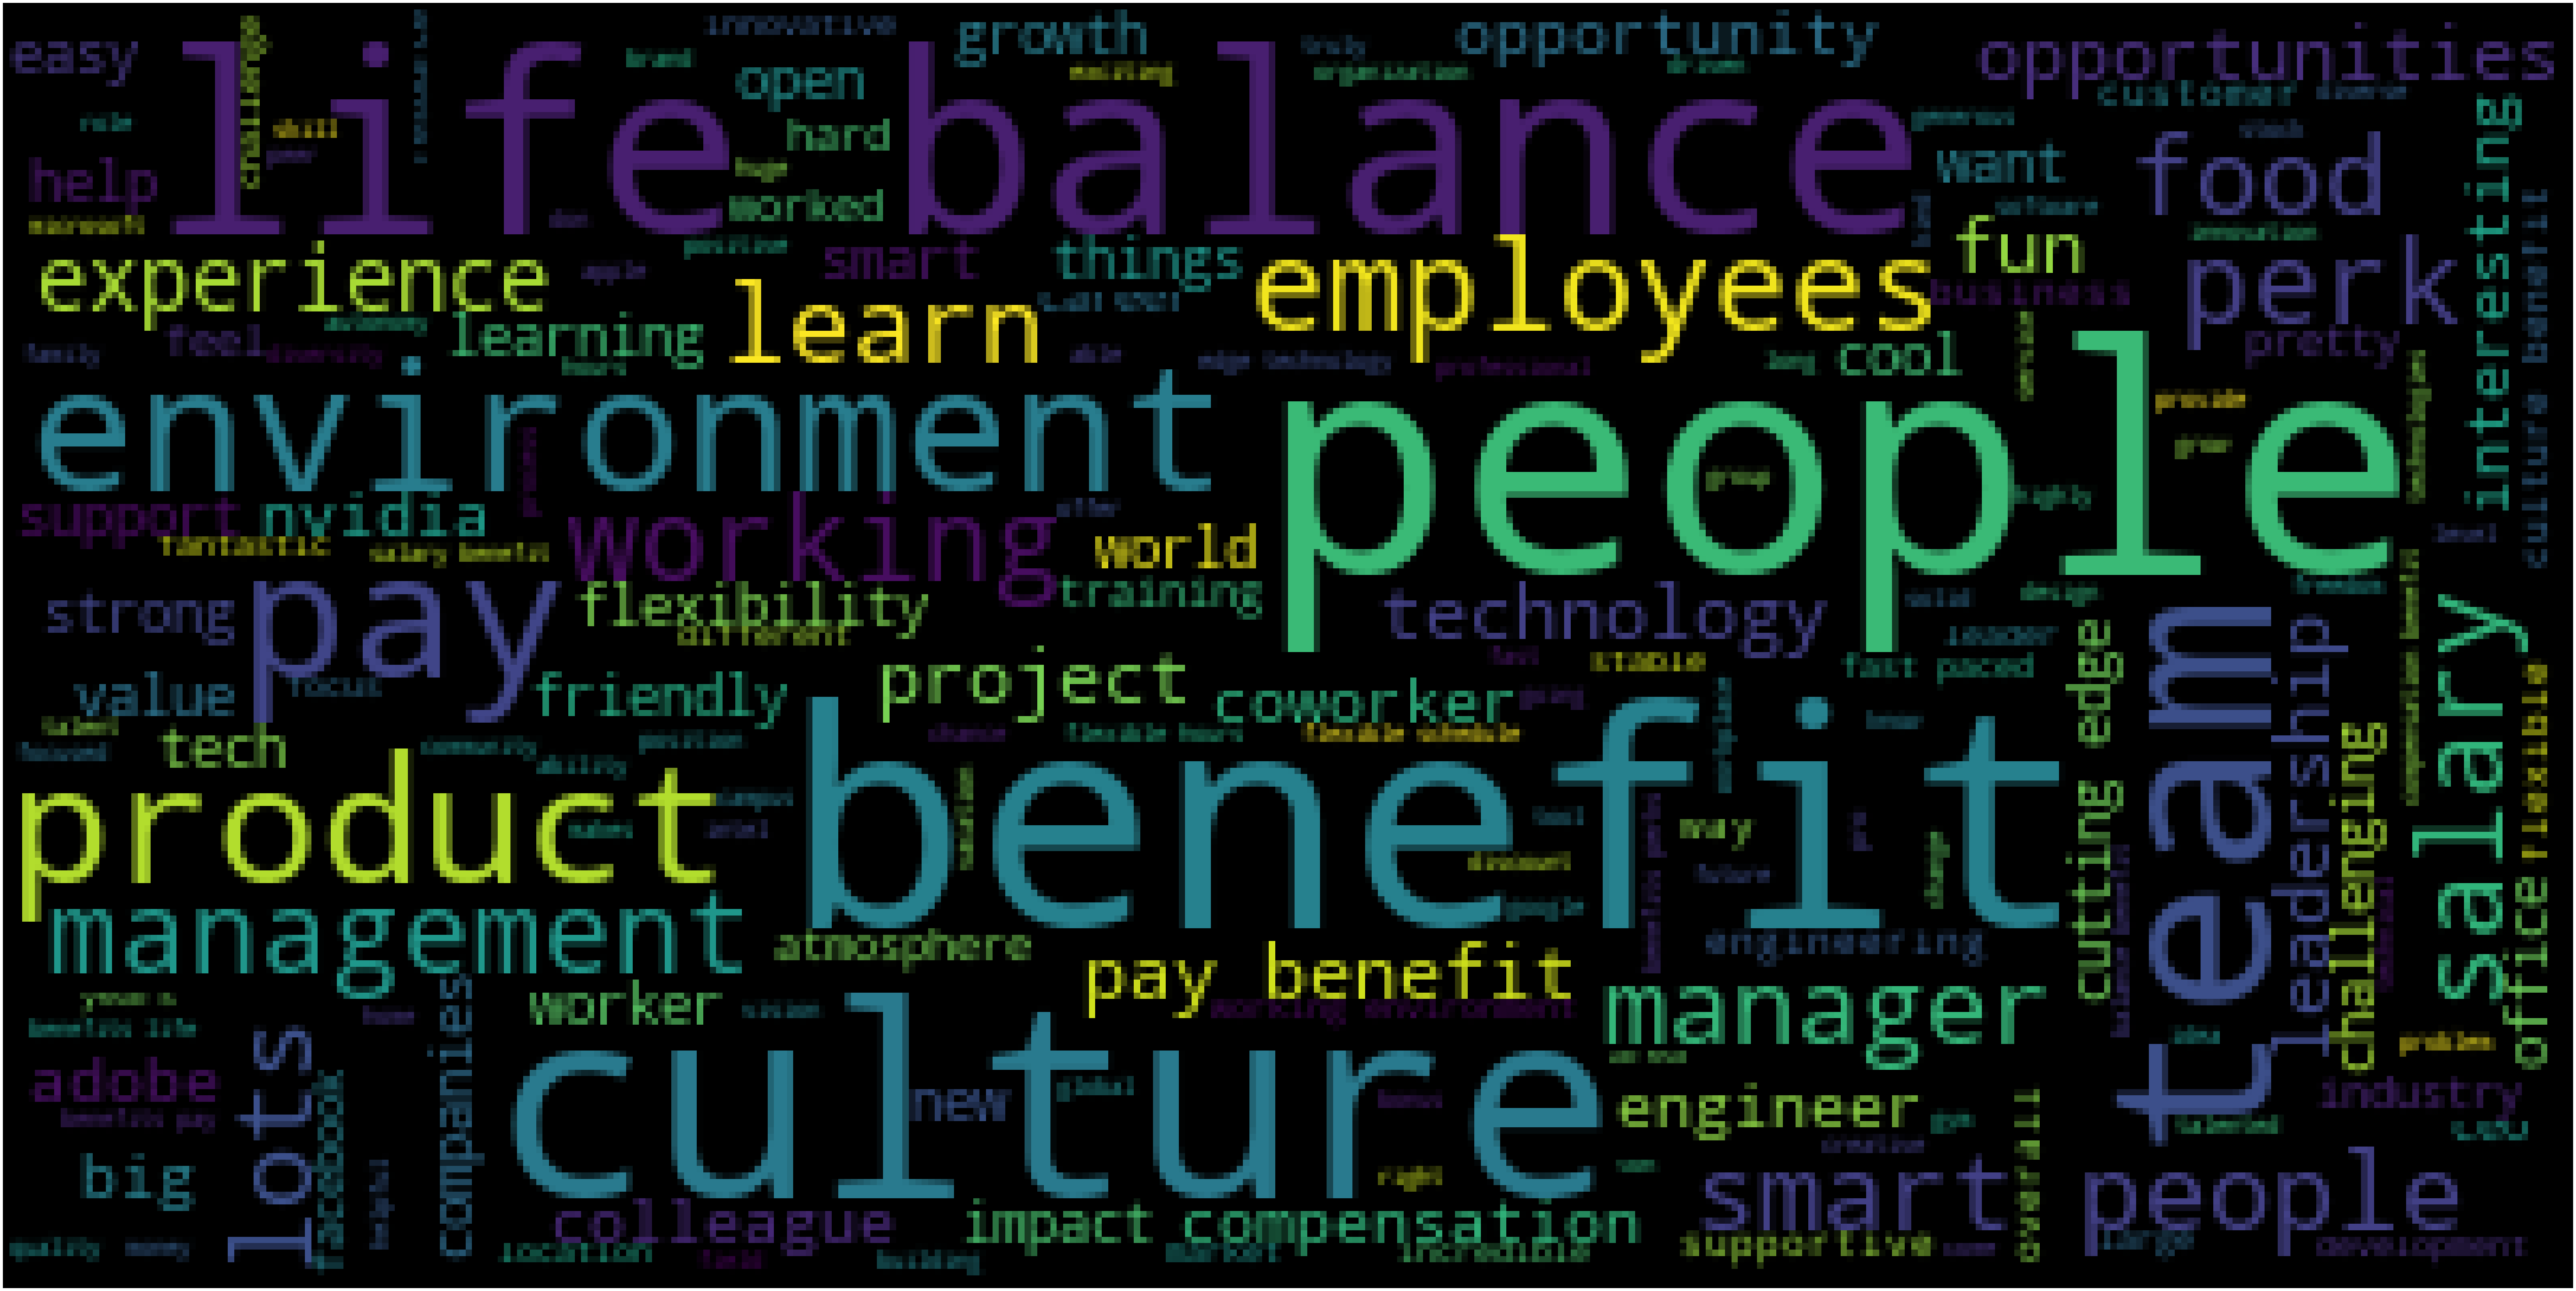

In [222]:
wc(cleaned_data_title,'black','Common Words' )

In [223]:
top_N = 100
#convert list of list into text

#a = data['lem_con'].str.lower().str.cat(sep=' ')
a = data['cons'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
#stop_words = list(get_stop_words('en'))         
#nltk_words = list(stopwords.words('english'))   
#stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in STOPLIST]
filtered_sentence = []
for w in word_tokens:
    if w not in STOPLIST:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

#### Frequency word count of negative words

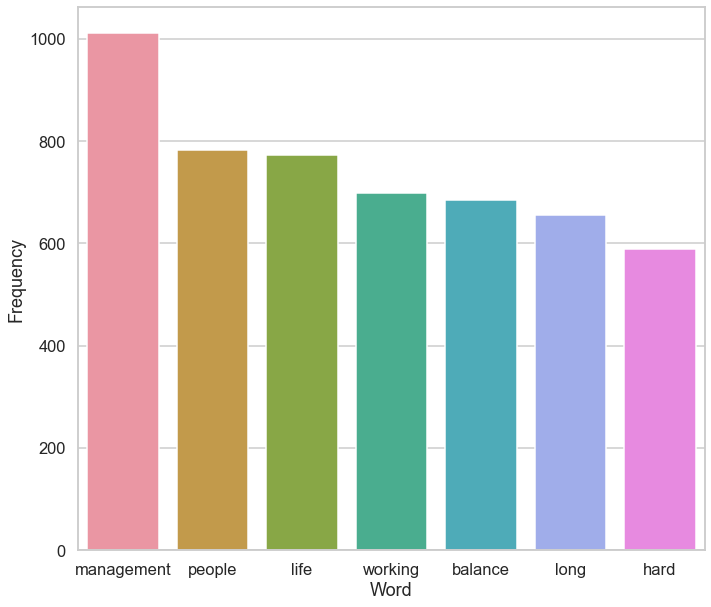

In [224]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

#### Wordcloud of negative words

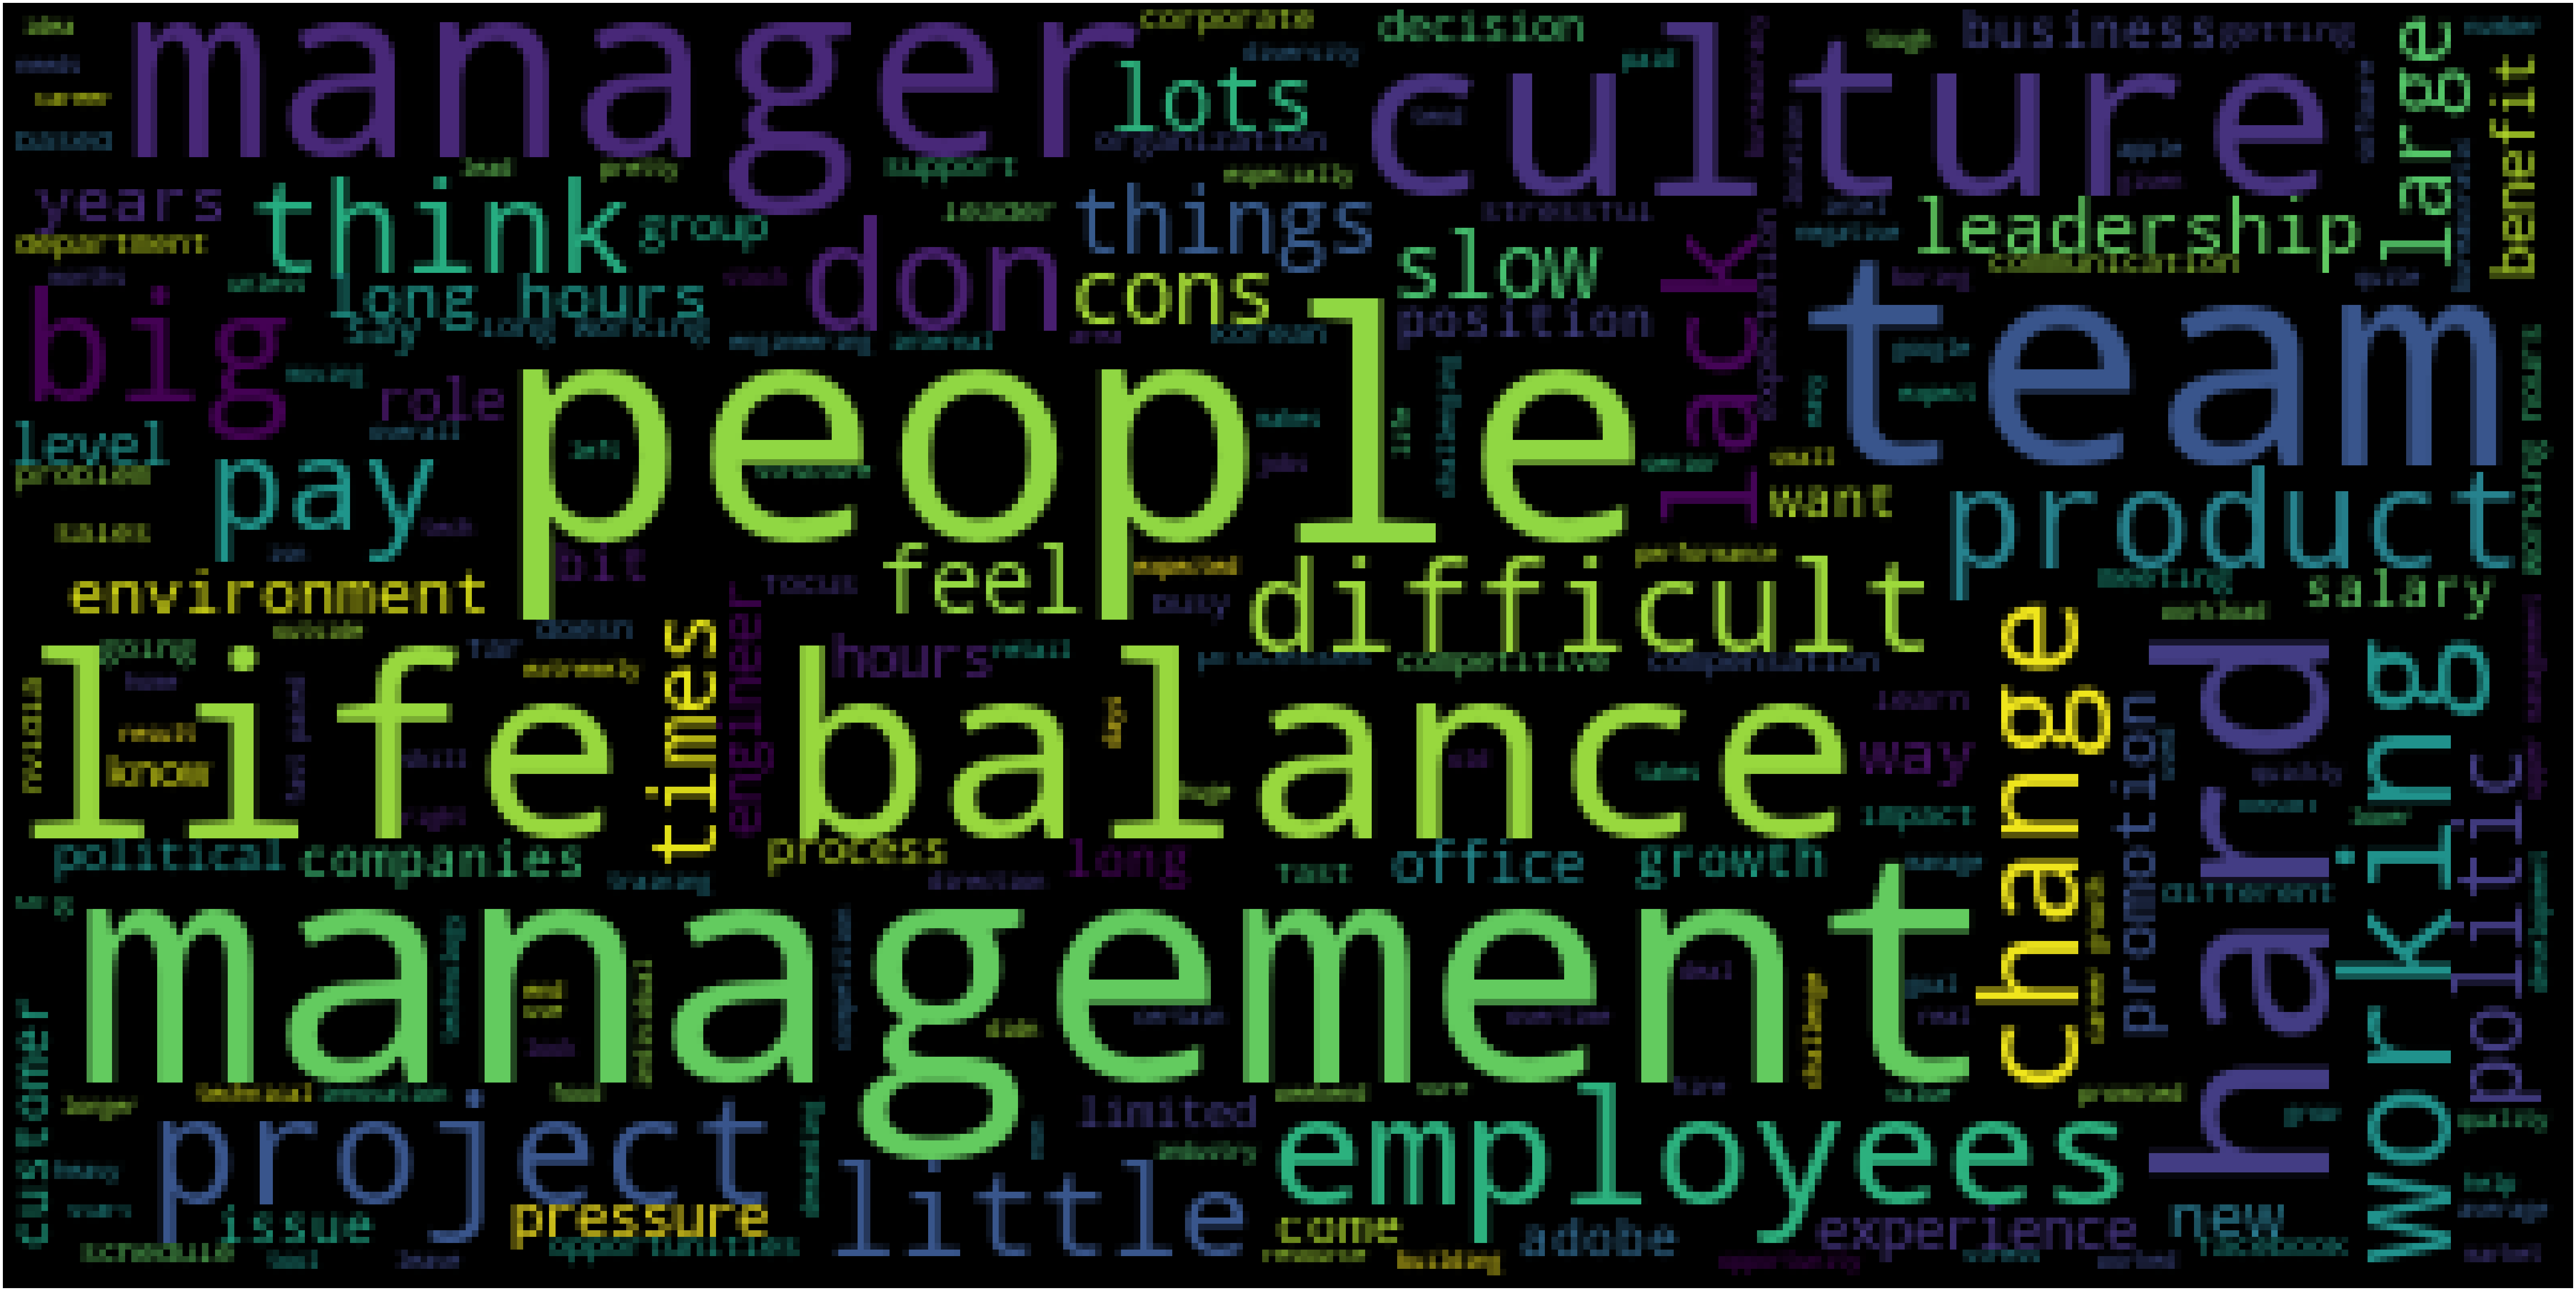

In [225]:
wc(cleaned_data_title,'black','Common Words' )

As shown above, we originally explored the implementation of a classifier of the sentiment of the reviews combining both pros and cons columns. However, to fulfill our business need of creating a ranking that accurately reflects how the public feels about a company, a mere classification of positive vs. negative is not sufficient. Therefore, we took it one step further by analyzing the pros and cons columns separately and calculating a score that takes into account not only the polarity but also subjectivity of a review. Therefore, we have chosen to use the TextBlob package for our final analysis, as shown below:

# V. Sentiment Polarity and Subjectivity

In [226]:
#NLP packages, uncomment packages to install as needed
#!pip install -U textblob
from textblob import TextBlob

#Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [227]:
comments = data[['Company','date','location','years_at_company','review_title','pros','cons','rating_overall']]
comments.head(3)

,Company,date,location,years_at_company,review_title,pros,cons,rating_overall
0,ADOBE,Fri Dec 04 2020 10:16:51 GMT+0100 (hora estánd...,"San Jose, CA",I worked at Adobe full-time for more than 10 y...,Good Company,- Great Benefits - Great Comp - Very good culture,- Sometime too consensus driven,4.0
1,ADOBE,Thu Nov 19 2020 04:31:24 GMT+0100 (hora estánd...,"New York, NY",I worked at Adobe full-time,adobe review,good people good environment good things,"nothing bad, good things everything",5.0
2,ADOBE,Thu Nov 19 2020 19:18:17 GMT+0100 (hora estánd...,"Lehi, UT",I have been working at Adobe full-time for mor...,Phenomenal company that puts its employees exp...,-Paid Holidays -Shutdown bi-annually -Maternit...,Aetna insurance has separate deductibles for m...,4.0


## 5.1. Title

In [228]:
#Calculating the Sentiment Polarity and subjectivity
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in comments['review_title'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)

#Adding the Sentiment Polarity column to the data
comments['polarity_title']=polarity
comments['subjectivity_title']=subjectivity

In [229]:
#Displaying pro comments with its polarity and subjectivity
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth',-1): 
    display(comments[['Company','review_title','polarity_title','subjectivity_title']].head(10))

,Company,review_title,polarity_title,subjectivity_title
0,ADOBE,Good Company,0.700000,0.600000
1,ADOBE,adobe review,0.000000,0.000000
2,ADOBE,Phenomenal company that puts its employees experience first.,0.375000,0.416667
3,ADOBE,"Would recommend to anybody, best place for tech work in UT!",1.000000,0.300000
4,ADOBE,A great place to work!,1.000000,0.750000
5,ADOBE,Adobe Rocks!,0.000000,0.000000
6,ADOBE,#AdobeLife is DOPE,0.000000,0.000000
7,ADOBE,"Incredible support and resources for diversity and inclusion, social justice",0.466667,0.483333
8,ADOBE,"The Best Work Culture Out There, Full Stop",0.675000,0.425000
9,ADOBE,Abusive sales comp situation - keep looking,0.000000,0.000000


## 5.2. Pro Comments

In [230]:
#Calculating the Sentiment Polarity and subjectivity
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in comments['pros'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)

#Adding the Sentiment Polarity column to the data
comments['polarity_pros']=polarity
comments['subjectivity_pros']=subjectivity

In [231]:
#Displaying pro comments with its polarity and subjectivity
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth',-1): 
    display(comments[['Company','pros','polarity_pros','subjectivity_pros']].sort_values(by='polarity_pros',ascending=False).head(10))

,Company,pros,polarity_pros,subjectivity_pros
681,MICROSOFT,Best place to work for,1.0,0.300000
708,MICROSOFT,Best place to work at,1.0,0.300000
551,APPLE,"Get to work with some of the best people in your field. Lots of infrastructure built into the company for employees to use ranging from software tools, to an office gym and hospital to transportation subsidy programs",1.0,0.300000
724,MICROSOFT,Awesome culture and continue to promote talents,1.0,1.000000
728,MICROSOFT,Best place to work for,1.0,0.300000
827,MICROSOFT,The culture was really great!,1.0,0.750000
880,MICROSOFT,"Best culture, work, work life balance and benefits",1.0,0.300000
404,APPLE,"The benefits and pay were great! They gave you stock, awesome health insurance, HSA, great Apple discounts!",1.0,0.833333
354,APPLE,Apple is committed to creating a great environment for their employees. They have been flexible with my college schedule and offer benefits even to part-timers!,1.0,0.750000
984,MICROSOFT,Awesome Technology and People at Microsoft,1.0,1.000000


## 5.3. Con Comments

In [232]:
#Calculating the Sentiment Polarity and subjectivity
polarity=[] # list which will contain the polarity of the comments
subjectivity=[] # list which will contain the subjectivity of the comments
for i in comments['cons'].values:
    try:
        analysis =TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
        
    except:
        polarity.append(0)
        subjectivity.append(0)

#Adding the Sentiment Polarity column to the data
comments['polarity_cons']=polarity
comments['subjectivity_cons']=subjectivity

In [233]:
#Displaying pro comments with its polarity and subjectivity
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth',-1): 
    display(comments[['Company','cons','polarity_cons','subjectivity_cons']].sort_values(by='polarity_cons',ascending=True).head(10))

,Company,cons,polarity_cons,subjectivity_cons
119,TSMC,"toxic working environment, terrible management.",-1.0,1.0
777,GOOGLE,Terrible pay and treatment. Do not work here it is awful,-1.0,1.0
831,GOOGLE,It got boring at times,-1.0,1.0
393,FACEBOOK,Worst job ever Wouldn’t do it again,-1.0,1.0
519,FACEBOOK,Facebook is the worst thing to happen to humanity since smallpox,-1.0,1.0
849,MICROSOFT,Boring. Some product teams lack direction.,-1.0,1.0
565,APPLE,Management is usually terrible but it depends on the store,-1.0,1.0
330,NVIDIA,Micro-manager who would sabotage projects and then swoop in to save the day. Received no assistance from HR. Nvidia is a candidate for the worst job I've ever had.,-1.0,1.0
881,NVIDIA,life can get miserable if the management is clueless,-1.0,1.0
895,INTEL,"Terrible culture, no growth opportunities, skills under utilized, chaotic",-1.0,1.0


# VI. Overall Review Score Calculation

#### Calculation rules

- Subjectivity is averaged between title, pros and cons to get an average subjectivity of the review
- Polarity of title, pros and cons are added together to determine which sentiment score wins out, the higher pro polarity is than con polarity, the more positive the overall polarity is, likewise the higher lower the con polarity is than pro polarity the more negative the overall polarity is
- Polarity score is then weighted by 1-averge subjectivity to award higher score to less subjective reviews compared to more subjective reviews

In [234]:
comments['overall_score'] = (comments['polarity_title']+comments['polarity_pros']+comments['polarity_cons'])*(1-((comments['subjectivity_pros']+comments['subjectivity_cons']+comments['subjectivity_title'])/3))
comments.head(3)

,Company,date,location,years_at_company,review_title,pros,cons,rating_overall,polarity_title,subjectivity_title,polarity_pros,subjectivity_pros,polarity_cons,subjectivity_cons,overall_score
0,ADOBE,Fri Dec 04 2020 10:16:51 GMT+0100 (hora estánd...,"San Jose, CA",I worked at Adobe full-time for more than 10 y...,Good Company,- Great Benefits - Great Comp - Very good culture,- Sometime too consensus driven,4.0,0.700,0.600000,0.836667,0.76,0.000000e+00,0.000000,0.840044
1,ADOBE,Thu Nov 19 2020 04:31:24 GMT+0100 (hora estánd...,"New York, NY",I worked at Adobe full-time,adobe review,good people good environment good things,"nothing bad, good things everything",5.0,0.000,0.000000,0.700000,0.60,5.551115e-17,0.633333,0.412222
2,ADOBE,Thu Nov 19 2020 19:18:17 GMT+0100 (hora estánd...,"Lehi, UT",I have been working at Adobe full-time for mor...,Phenomenal company that puts its employees exp...,-Paid Holidays -Shutdown bi-annually -Maternit...,Aetna insurance has separate deductibles for m...,4.0,0.375,0.416667,0.000000,0.00,0.000000e+00,0.000000,0.322917


# VII. Evaluation

As we are dealing with an unsupervised technique of scoring each review, the team came up with our own solution of attempting to evaluate our scores. The method makes use of existing ratings for each review as the baseline for to gauge each review's positivity/negativity. We then binned our scores taking into account distribution as well as range to match the aforemention ratings. This method does have its limitations as many public sentiment sources like Twitter would not have an existing rating to benchmark.

In [235]:
comments['rating_overall'] = round(comments['rating_overall'])

conditions = [
    (comments['overall_score'] <= 0),
    ((comments['overall_score'] > 0) & (comments['overall_score'] <= 0.3)),
    ((comments['overall_score'] > 0.3) & (comments['overall_score'] <= 0.6)),
    ((comments['overall_score'] > 0.6) & (comments['overall_score'] <= 0.9)),
    (comments['overall_score'] > 0.9)
    ]

values = [1, 2, 3, 4, 5]

comments['Rank'] = np.select(conditions, values)

In [236]:
comments_cleaned = comments[comments['rating_overall'].notnull()]

In [237]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

print("The error of the calculated scores to existing ratings is about: " + str(round(mape(comments_cleaned['rating_overall'], comments_cleaned['Rank']),2)) + "%")

The error of the calculated scores to existing ratings is about: 32.38%


# VIII. Export Final Output

In [238]:
# Status
comments['status'] = np.where(comments['years_at_company'].str.contains("worked", case=False, na=False), 'ex', 'current')

# Emp_type
conditions = [
    (comments['years_at_company'].str.contains("full-time", case=False, na=False)),
    (comments['years_at_company'].str.contains("part-time", case=False, na=False)),
    (comments['years_at_company'].notnull())
    ]

# create a list of the values we want to assign for each condition
values = ['full-time', 'part-time','unknown']

# create a new column and use np.select to assign values to it using our lists as arguments
comments['emptype'] = np.select(conditions, values)

# display updated DataFrame
comments.head()

# Working_years
comments["working_years"]=0
for i in range(len(comments)):
    num = sum([int(s) if s.isdigit() else 0 for s in comments.iloc[i,:]['years_at_company'].split() ])
    comments.iloc[i,-1] = num
    
comments['working_years'] = np.where(comments['years_at_company'].str.contains("a year", case=False, na=False), int(1), comments['working_years'])

condition1 = [
    (comments['years_at_company'].str.contains("more", case=False, na=False)),
    (comments['years_at_company'].str.contains("less", case=False, na=False)),
    (comments['years_at_company'].notnull())
    ]

values = [comments["working_years"]+0.5, comments["working_years"]-0.5,comments["working_years"]]
comments['working_years'] = np.select(condition1, values)

comments.head(5)

,Company,date,location,years_at_company,review_title,pros,cons,rating_overall,polarity_title,subjectivity_title,polarity_pros,subjectivity_pros,polarity_cons,subjectivity_cons,overall_score,Rank,status,emptype,working_years
0,ADOBE,Fri Dec 04 2020 10:16:51 GMT+0100 (hora estánd...,"San Jose, CA",I worked at Adobe full-time for more than 10 y...,Good Company,- Great Benefits - Great Comp - Very good culture,- Sometime too consensus driven,4.0,0.700,0.600000,0.836667,0.76000,0.000000e+00,0.000000,0.840044,4,ex,full-time,10.5
1,ADOBE,Thu Nov 19 2020 04:31:24 GMT+0100 (hora estánd...,"New York, NY",I worked at Adobe full-time,adobe review,good people good environment good things,"nothing bad, good things everything",5.0,0.000,0.000000,0.700000,0.60000,5.551115e-17,0.633333,0.412222,3,ex,full-time,0.0
2,ADOBE,Thu Nov 19 2020 19:18:17 GMT+0100 (hora estánd...,"Lehi, UT",I have been working at Adobe full-time for mor...,Phenomenal company that puts its employees exp...,-Paid Holidays -Shutdown bi-annually -Maternit...,Aetna insurance has separate deductibles for m...,4.0,0.375,0.416667,0.000000,0.00000,0.000000e+00,0.000000,0.322917,3,current,full-time,1.5
3,ADOBE,Wed Nov 18 2020 03:54:20 GMT+0100 (hora estánd...,"Lehi, UT",I have been working at Adobe full-time for mor...,"Would recommend to anybody, best place for tec...",The ESPP is by far the best benefit that is pr...,"Advancement is a slow process, and there has h...",4.0,1.000,0.300000,0.168750,0.79375,-1.238095e-01,0.180952,0.600944,4,current,full-time,3.5
4,ADOBE,Tue Nov 10 2020 08:57:27 GMT+0100 (hora estánd...,"Denver, CO",I worked at Adobe full-time for more than a year,A great place to work!,"Great company culture, good benefits, compelli...","Because the company is so large, the growing n...",5.0,1.000,0.750000,0.600000,0.65000,3.228571e-01,0.495714,0.707795,4,ex,full-time,1.5


In [239]:
location_mapping = pd.read_csv(r'C:\Users\34603\IE Students\Las Bombas - Documents\NLP\NLP_Dashboard_Location_Mapping.csv',index_col = False)

comments[['date', 'extra']] = comments['date'].str.split('G',expand=True)
comments['date'] = pd.to_datetime(comments['date'])
comments["date"] = comments["date"].astype(str).str[0:24]
comments["date"] = pd.to_datetime(comments["date"]).apply(lambda x:x.date())
comments['Industry'] = "Technology"
comments['Source'] = "Glassdoor"
comments = comments.merge(right=location_mapping, how='inner', left_on=comments['location'], right_on=location_mapping['Original'])
comments['Rank'] = comments.Rank.astype(str) + " " + "Star"
comments.head(3)

,key_0,Company,date,location,years_at_company,review_title,pros,cons,rating_overall,polarity_title,...,emptype,working_years,extra,Industry,Source,Original,City,State_Code,State_Name,Country
0,"San Jose, CA",ADOBE,2020-12-04,"San Jose, CA",I worked at Adobe full-time for more than 10 y...,Good Company,- Great Benefits - Great Comp - Very good culture,- Sometime too consensus driven,4.0,0.7,...,full-time,10.5,MT+0100 (hora estándar de Europa central),Technology,Glassdoor,"San Jose, CA",San Jose,CA,California,United States
1,"San Jose, CA",ADOBE,2020-10-19,"San Jose, CA",I have been working at Adobe full-time for mor...,"Focused, great products, great core values","Creative products, great work-life balance, gr...",They have grown a little too large (loss of in...,5.0,0.8,...,full-time,5.5,MT+0200 (hora de verano de Europa central),Technology,Glassdoor,"San Jose, CA",San Jose,CA,California,United States
2,"San Jose, CA",ADOBE,2020-10-13,"San Jose, CA",I have been working at Adobe full-time,Great work culture!,Great culture to work at! Love my coworkers.,Hard to move out of sales.,5.0,1.0,...,full-time,0.0,MT+0200 (hora de verano de Europa central),Technology,Glassdoor,"San Jose, CA",San Jose,CA,California,United States


In [247]:
comments.to_csv(r'C:\Users\34603\IE Students\Las Bombas - Documents\NLP\NLP_Final_Submission_Teamb\8_code_output.csv')

# IX. Information Retrieval

In [241]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

stopwords_english = set(stopwords.words('english'))
from __future__ import division
import time
from math import log

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34603\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [242]:
# User decides whether to choose pros or cons
pros = True
cons = True

if (pros==True & cons==True):
    #merge pros and cons and search on both
    comments["both"] = "PROS: " + comments["pros"] + " " + "CONS: " + comments["cons"]
    columna = len(comments.columns)-1
    selection = "Pros and Cons"
elif select_con:
    columna = comments.columns.get_loc('cons')
    selection = "Cons"
else:
    #By default, if user does not specify, get pros
    columna = comments.columns.get_loc('pros')
    selection = "Pros"

In [243]:
from nltk.stem import *

def get_list_tokens_string(string):
    list_words = re.split(r'\W+',string)
    list_words = [w.lower() for w in list_words if w.isalpha() and len(w)>1 and w.lower() not in stopwords_english]  
    stemmer = PorterStemmer()
    list_words = [stemmer.stem(w) for w in list_words]
    return list_words

def index_one_file(termlist):
    fileIndex = {}
    for index, word in enumerate(termlist):
        if word in fileIndex.keys():
            fileIndex[word].append(index)
        else:
            fileIndex[word] = [index]
    return fileIndex

## 9.1. Main IR

### Option 1: TF/IDF

In [244]:
start_time = time.time()    
list_document_ids =  comments.index #get_list_fileids(corpus)   
num_docs = len(list_document_ids)      

##1) Create a inverted index
inverted_index = {}

##2)Loop through the dataset, to get the entire text from  each file
for document_index in list_document_ids:
    
    ##3) Parse the string to get individual words    
    list_words = get_list_tokens_string(comments.iloc[document_index,columna])
    
    ##4) Update the dictionary to use tf-idf 
    for w in list_words:
        if inverted_index.get(w,0)==0:
            inverted_index[w]={}
            inverted_index[w][document_index]=1
        else:
            inverted_index[w][document_index] = inverted_index[w].get(document_index,0)
            inverted_index[w][document_index] += 1
    for w in set(list_words):
        inverted_index[w][document_index]=1+log(inverted_index[w][document_index])

        
# print "Inverted Index has been prepared and it took"
# print time.time() - start_time, "seconds"

##5) Getting the query from the user
query = input("Enter your query string : ")
result_file_dict={}

start_time = time.time()

##6) Tokenizing query string to get individual words
query_list = get_list_tokens_string(query)

##7) Calculating tf-idf scores 
for q in query_list:
    d = inverted_index.get(q,0) 
    if d!=0:
        length=len(d)
        for file_index in d.keys():
            result_file_dict[file_index] = result_file_dict.get(file_index,0)
            result_file_dict[file_index]+=((1+log(d[file_index]))*(log(num_docs/length)/log(10)))
                                        #1st term is tf # 2nd term is idf

##8) Sorting the dictionary based on its values            
result_file_indices = sorted(result_file_dict.items(), key=lambda x:x[1],reverse = True)

# print("Time taken to search")
# print (time.time() - start_time), "seconds"

if(len(result_file_indices)==0):
    print("Sorry No matches found")
else:
#     print "Number of search results : " , len(result_file_indices)
#     print "Results:"
#     print "\n"
    if len(result_file_indices) > 10:
         print("Returning 1st 10 results")
    for (index,tup) in enumerate(result_file_indices):
        if index==10:
            break
#         print get_raw_text(corpus, list_document_ids[tup[0]])
        
        print(comments.iloc[index,1].upper())
        print(" --- ")
        print(comments.iloc[index,columna])
        print("\n")

Enter your query string : good salary
Returning 1st 10 results
ADOBE
 --- 
PROS: - Great Benefits - Great Comp - Very good culture CONS: - Sometime too consensus driven


ADOBE
 --- 
PROS: Creative products, great work-life balance, great values. CONS: They have grown a little too large (loss of intimacy).


ADOBE
 --- 
PROS: Great culture to work at! Love my coworkers. CONS: Hard to move out of sales.


ADOBE
 --- 
PROS: Team and Engineers are wonderful to work with and most benefits are good. CONS: HR policies and red tape get very annoying as well as non competitive salaries.


ADOBE
 --- 
PROS: Employee empowerment, great benefits, and career opportunity CONS: Can't think of anything at this time


ADOBE
 --- 
PROS: Benefits, general environment is great. Good people to work with. CONS: Hard to move around, relatively siloed business units.


ADOBE
 --- 
PROS: Great health benefits for employees. CONS: Lots of reorganization / job shifts


ADOBE
 --- 
PROS: Always good coffee with 

### Option 2: Phrase Queries

In [245]:
start_time = time.time()    
list_document_ids =  comments.index #get_list_fileids(corpus)   
num_docs = len(list_document_ids)    

##1) Create a inverted index
inverted_index = {}

## 2)Loop through the dataset, to get the entire text from  each file
for document_index in list_document_ids:
    list_words = get_list_tokens_string(comments.iloc[document_index,columna])
    list_words_pos = index_one_file(list_words)
    
    ## 3) Update the dictionary with the words in the document and the related document_id
    for w in set(list_words):
        if w in inverted_index.keys():
            if document_index in inverted_index[w].keys():
                inverted_index[w][document_index].extend(list_words_pos[w][:])
            else:
                inverted_index[w][document_index] = list_words_pos[w]
        else:
            inverted_index[w] = {document_index: list_words_pos[w]}

In [246]:
##5) Getting the query from the user
query = input("Enter your query string : ")
#query_list = get_list_tokens_string(query)
result_file_indices= []
# result_file_dict={}
result = []

start_time = time.time()

##6) Tokenizing query string to get individual words
query_list = get_list_tokens_string(query)

##7) Get the documents including the query terms
for q in query_list:
    if q in inverted_index.keys():
        result_file_indices.append([filename for filename in inverted_index[q.lower()]])

setted = set(result_file_indices[0]).intersection(*result_file_indices)

for filename in setted:
    temp = []
    for word in query_list:
        temp.append(inverted_index[word][filename][:])
    for i in range(len(temp)):
        for ind in range(len(temp[i])):
            temp[i][ind] -= i
    if set(temp[0]).intersection(*temp):
        result.append(filename)

##8) Sorting the dictionary based on its values            

if(len(result)==0):
    print("Sorry No matches found")
else:
    print("Number of search results : " , len(result))
    print("Results:")
    print("\n")
    for index in result:
        print(comments.iloc[index,1].upper())
        print(" --- ")
        print(comments.iloc[index,columna])
        print("\n")

Enter your query string : good salary
Number of search results :  123
Results:


MICROSOFT
 --- 
PROS: Open culture, great benefits, good salary CONS: Long hours and overnight support


SAMSUNG
 --- 
PROS: Good salary and work is good CONS: Heavy work &eavy wotk work


NVIDIA
 --- 
PROS: Good salary, leave policy, medical assistance, free transport, food, work from home CONS: Nothing as of now, work on reducing taxes by giving sodexo coupons for those who want


GOOGLE
 --- 
PROS: Very good salary and benefits CONS: Not really any cons to say


NVIDIA
 --- 
PROS: - family - growth potential - experience - benefits - good salary CONS: big no food medium insurance not chip leasing overwork


NVIDIA
 --- 
PROS: good salary, excellent leadership of CEO CONS: lack of gym, it's hard to make work/life balance


TSMC
 --- 
PROS: Use newest technology, big company name, good salary and benefits, able to know the procedure in big corporation CONS: Close environment (cannot use smartphone, YouTub